# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

----
1. dict form, nifti image
2. channel을 더함
3. 이미지 intensity를 scaling
4. potitive, nefative label에 따라 crop(멀티엔 사용하기가..?)
5. 캐쉬IO와 transform활용 빠르게 함
6. 3D UNet model, Dice loss function, Mean Dice metric
7. Sliding window 추론 방법
8. Deterministic training? 

## Setup environment

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

In [1]:
# set_determinism : monai에서 제공하는 seed값 고정 util.
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.9.dev2152
Numpy version: 1.21.2
Pytorch version: 1.10.0a0+0aef44c
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: c5bd8aff8ba461d7b349eb92427d452481a7eb72

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: 4.2.0
TorchVision version: 0.11.0a0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.3.2
transformers version: 4.12.5
mlflow version: 1.21.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = 'data/spleen/'
print(root_dir)

data/spleen/


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:27, 18.4MB/s]                                                                                              


2022-02-03 01:31:06,817 - INFO - Downloaded: data/spleen/Task09_Spleen.tar
2022-02-03 01:31:09,773 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-02-03 01:31:09,775 - INFO - Writing into directory: data/spleen/.


## Set MSD Spleen dataset path

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [6]:
len(data_dicts)

41

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

------------------
1. `LoadImaged` : 이미지와 라벨 로딩
1. `AddChanneld` "channel first" shape으로 C dim 추가
1. `Spacingd` 어파인 행렬을 기반으로 간격 조정by `pixdim=(1.5, 1.5, 2.)` - 뭥미.. ??
1. `Orientationd` 어파인 행렬 기반으로 데이터 방향 통합..??
1. `ScaleIntensityRanged` [-57, 164] 범위 값을 추출하여 [0, 1]사이로 스케일링
1. `CropForegroundd` 이미지와 라벨의 유효한 영역에 초점 맞추기 위하여 모든 0 경계들을 제거 ..??
1. `RandCropByPosNegLabeld` pos / neg ratio에 따라 랜덤하게 패치 크롭생성
1. `RandAffined` 어파인 변환에 기반하여  `rotate`, `scale`, `shear`, `translate`을 진행
1. `EnsureTyped` np를 tensor로 변환

In [9]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),    ## ?필수 일까? 아님. 1.0 1.0 1.0으로 바꿔주면됌
        Orientationd(keys=["image", "label"], axcodes="RAS"),   ## 이미지의 방향을 바꿔주는 transform
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),   ## ??? 찾아보자
        
        ### 이건 training set에서만
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


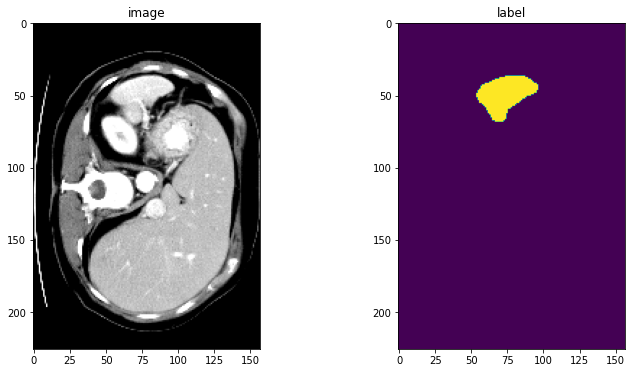

In [10]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [11]:
check_data

{'image': tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0.

In [13]:
# B, C(1) , W, H, D
# 3d image에선 shape이 같다.
check_data['image'].shape, check_data['label'].shape

(torch.Size([1, 1, 226, 157, 113]), torch.Size([1, 1, 226, 157, 113]))

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

----
Cache를 이용하여 train, validation 과정을 가속화. 일반적인 Dataset을 이용할 때보다 10배 정도 빠름. `cache_rate=1.0`를 설정하면 가장 빠르나 메모리가 충분하지 않으면 더 낮을 값을 설정하면 된다. `cache_rate` 대신 `cache_num`을 사용할 수도 있으나 둘중 하나는 꼭 사용해야 한다. cache중에 다중스레드 사용하도록 `num_workers` 사용가능하다.

아래 코드를 보면 알겠지만, Dataset() 대신 CacheDataset()을 사용하는 것이다. 이후 DataLoader()를 사용하는 것은 같다.

In [14]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.03s/it]


## Create Model, Loss, Optimizer

In [15]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:6")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [16]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/16, train_loss: 0.6764
2/16, train_loss: 0.6668
3/16, train_loss: 0.6652
4/16, train_loss: 0.6722
5/16, train_loss: 0.6516
6/16, train_loss: 0.6677
7/16, train_loss: 0.6541
8/16, train_loss: 0.6686
9/16, train_loss: 0.6717
10/16, train_loss: 0.6597
11/16, train_loss: 0.6410
12/16, train_loss: 0.6550
13/16, train_loss: 0.6427
14/16, train_loss: 0.6479
15/16, train_loss: 0.6413
16/16, train_loss: 0.6506
epoch 1 average loss: 0.6583
----------
epoch 2/600
1/16, train_loss: 0.6325
2/16, train_loss: 0.6540
3/16, train_loss: 0.6335
4/16, train_loss: 0.6403
5/16, train_loss: 0.6228
6/16, train_loss: 0.6322
7/16, train_loss: 0.6153
8/16, train_loss: 0.6285
9/16, train_loss: 0.6143
10/16, train_loss: 0.6359
11/16, train_loss: 0.6314
12/16, train_loss: 0.6532
13/16, train_loss: 0.6073
14/16, train_loss: 0.6167
15/16, train_loss: 0.6199
16/16, train_loss: 0.6221
epoch 2 average loss: 0.6287
saved new best metric model
current epoch: 2 current mean dice: 0.0426
best mean d

3/16, train_loss: 0.4988
4/16, train_loss: 0.4363
5/16, train_loss: 0.5395
6/16, train_loss: 0.4952
7/16, train_loss: 0.5147
8/16, train_loss: 0.4979
9/16, train_loss: 0.4891
10/16, train_loss: 0.4675
11/16, train_loss: 0.5168
12/16, train_loss: 0.5714
13/16, train_loss: 0.5012
14/16, train_loss: 0.4587
15/16, train_loss: 0.4916
16/16, train_loss: 0.5202
epoch 17 average loss: 0.4997
----------
epoch 18/600
1/16, train_loss: 0.5480
2/16, train_loss: 0.5039
3/16, train_loss: 0.5470
4/16, train_loss: 0.5150
5/16, train_loss: 0.5229
6/16, train_loss: 0.4455
7/16, train_loss: 0.5713
8/16, train_loss: 0.4970
9/16, train_loss: 0.5473
10/16, train_loss: 0.4788
11/16, train_loss: 0.5159
12/16, train_loss: 0.4978
13/16, train_loss: 0.5306
14/16, train_loss: 0.4565
15/16, train_loss: 0.4891
16/16, train_loss: 0.4268
epoch 18 average loss: 0.5058
current epoch: 18 current mean dice: 0.0975
best mean dice: 0.1124 at epoch: 14
----------
epoch 19/600
1/16, train_loss: 0.5307
2/16, train_loss: 0.504

9/16, train_loss: 0.3959
10/16, train_loss: 0.4343
11/16, train_loss: 0.3977
12/16, train_loss: 0.3875
13/16, train_loss: 0.3668
14/16, train_loss: 0.4511
15/16, train_loss: 0.3395
16/16, train_loss: 0.4141
epoch 33 average loss: 0.4116
----------
epoch 34/600
1/16, train_loss: 0.3997
2/16, train_loss: 0.4335
3/16, train_loss: 0.3049
4/16, train_loss: 0.3833
5/16, train_loss: 0.4057
6/16, train_loss: 0.4320
7/16, train_loss: 0.3816
8/16, train_loss: 0.3897
9/16, train_loss: 0.3807
10/16, train_loss: 0.3308
11/16, train_loss: 0.4380
12/16, train_loss: 0.3411
13/16, train_loss: 0.3745
14/16, train_loss: 0.4285
15/16, train_loss: 0.4089
16/16, train_loss: 0.4773
epoch 34 average loss: 0.3944
current epoch: 34 current mean dice: 0.0795
best mean dice: 0.1239 at epoch: 20
----------
epoch 35/600
1/16, train_loss: 0.3624
2/16, train_loss: 0.3453
3/16, train_loss: 0.4031
4/16, train_loss: 0.4182
5/16, train_loss: 0.4400
6/16, train_loss: 0.4478
7/16, train_loss: 0.3969
8/16, train_loss: 0.450

16/16, train_loss: 0.4342
epoch 49 average loss: 0.3183
----------
epoch 50/600
1/16, train_loss: 0.2826
2/16, train_loss: 0.2872
3/16, train_loss: 0.3210
4/16, train_loss: 0.2924
5/16, train_loss: 0.2227
6/16, train_loss: 0.2799
7/16, train_loss: 0.3024
8/16, train_loss: 0.3123
9/16, train_loss: 0.2726
10/16, train_loss: 0.2876
11/16, train_loss: 0.3300
12/16, train_loss: 0.3386
13/16, train_loss: 0.2672
14/16, train_loss: 0.3848
15/16, train_loss: 0.3052
16/16, train_loss: 0.3998
epoch 50 average loss: 0.3054
current epoch: 50 current mean dice: 0.0897
best mean dice: 0.1239 at epoch: 20
----------
epoch 51/600
1/16, train_loss: 0.3118
2/16, train_loss: 0.3351
3/16, train_loss: 0.3611
4/16, train_loss: 0.2543
5/16, train_loss: 0.4112
6/16, train_loss: 0.3345
7/16, train_loss: 0.3334
8/16, train_loss: 0.4385
9/16, train_loss: 0.2969
10/16, train_loss: 0.2884
11/16, train_loss: 0.2453
12/16, train_loss: 0.2686
13/16, train_loss: 0.2851
14/16, train_loss: 0.3071
15/16, train_loss: 0.231

4/16, train_loss: 0.3433
5/16, train_loss: 0.2485
6/16, train_loss: 0.2434
7/16, train_loss: 0.2181
8/16, train_loss: 0.3666
9/16, train_loss: 0.3714
10/16, train_loss: 0.3632
11/16, train_loss: 0.2306
12/16, train_loss: 0.2866
13/16, train_loss: 0.2994
14/16, train_loss: 0.2569
15/16, train_loss: 0.2182
16/16, train_loss: 0.3193
epoch 66 average loss: 0.2832
current epoch: 66 current mean dice: 0.0753
best mean dice: 0.1370 at epoch: 52
----------
epoch 67/600
1/16, train_loss: 0.2544
2/16, train_loss: 0.2603
3/16, train_loss: 0.3318
4/16, train_loss: 0.2708
5/16, train_loss: 0.2787
6/16, train_loss: 0.2953
7/16, train_loss: 0.2105
8/16, train_loss: 0.2087
9/16, train_loss: 0.2332
10/16, train_loss: 0.2629
11/16, train_loss: 0.2644
12/16, train_loss: 0.3024
13/16, train_loss: 0.4124
14/16, train_loss: 0.2069
15/16, train_loss: 0.2986
16/16, train_loss: 0.2157
epoch 67 average loss: 0.2692
----------
epoch 68/600
1/16, train_loss: 0.4132
2/16, train_loss: 0.3345
3/16, train_loss: 0.212

8/16, train_loss: 0.2354
9/16, train_loss: 0.2795
10/16, train_loss: 0.2008
11/16, train_loss: 0.2572
12/16, train_loss: 0.2704
13/16, train_loss: 0.3434
14/16, train_loss: 0.2315
15/16, train_loss: 0.4021
16/16, train_loss: 0.3031
epoch 82 average loss: 0.2579
saved new best metric model
current epoch: 82 current mean dice: 0.4369
best mean dice: 0.4369 at epoch: 82
----------
epoch 83/600
1/16, train_loss: 0.2379
2/16, train_loss: 0.3011
3/16, train_loss: 0.2041
4/16, train_loss: 0.4024
5/16, train_loss: 0.2649
6/16, train_loss: 0.1822
7/16, train_loss: 0.2982
8/16, train_loss: 0.2945
9/16, train_loss: 0.1599
10/16, train_loss: 0.2121
11/16, train_loss: 0.2330
12/16, train_loss: 0.2073
13/16, train_loss: 0.2102
14/16, train_loss: 0.2303
15/16, train_loss: 0.2541
16/16, train_loss: 0.1851
epoch 83 average loss: 0.2423
----------
epoch 84/600
1/16, train_loss: 0.2463
2/16, train_loss: 0.4005
3/16, train_loss: 0.1928
4/16, train_loss: 0.2352
5/16, train_loss: 0.2503
6/16, train_loss: 0.

14/16, train_loss: 0.2262
15/16, train_loss: 0.3837
16/16, train_loss: 0.2843
epoch 98 average loss: 0.2529
current epoch: 98 current mean dice: 0.1682
best mean dice: 0.4369 at epoch: 82
----------
epoch 99/600
1/16, train_loss: 0.1352
2/16, train_loss: 0.1342
3/16, train_loss: 0.2366
4/16, train_loss: 0.1981
5/16, train_loss: 0.2323
6/16, train_loss: 0.1721
7/16, train_loss: 0.3102
8/16, train_loss: 0.2531
9/16, train_loss: 0.1672
10/16, train_loss: 0.2388
11/16, train_loss: 0.2366
12/16, train_loss: 0.2804
13/16, train_loss: 0.1933
14/16, train_loss: 0.2332
15/16, train_loss: 0.2215
16/16, train_loss: 0.2801
epoch 99 average loss: 0.2202
----------
epoch 100/600
1/16, train_loss: 0.2810
2/16, train_loss: 0.3465
3/16, train_loss: 0.1532
4/16, train_loss: 0.1622
5/16, train_loss: 0.2187
6/16, train_loss: 0.1689
7/16, train_loss: 0.2354
8/16, train_loss: 0.2751
9/16, train_loss: 0.2285
10/16, train_loss: 0.2693
11/16, train_loss: 0.3351
12/16, train_loss: 0.1470
13/16, train_loss: 0.17

1/16, train_loss: 0.1205
2/16, train_loss: 0.1498
3/16, train_loss: 0.1575
4/16, train_loss: 0.2153
5/16, train_loss: 0.1789
6/16, train_loss: 0.1239
7/16, train_loss: 0.1918
8/16, train_loss: 0.2732
9/16, train_loss: 0.1607
10/16, train_loss: 0.1625
11/16, train_loss: 0.1892
12/16, train_loss: 0.2762
13/16, train_loss: 0.2171
14/16, train_loss: 0.1739
15/16, train_loss: 0.2165
16/16, train_loss: 0.2753
epoch 115 average loss: 0.1926
----------
epoch 116/600
1/16, train_loss: 0.2833
2/16, train_loss: 0.1588
3/16, train_loss: 0.2210
4/16, train_loss: 0.1077
5/16, train_loss: 0.2788
6/16, train_loss: 0.2659
7/16, train_loss: 0.2144
8/16, train_loss: 0.1577
9/16, train_loss: 0.1048
10/16, train_loss: 0.1660
11/16, train_loss: 0.2728
12/16, train_loss: 0.0649
13/16, train_loss: 0.2745
14/16, train_loss: 0.0521
15/16, train_loss: 0.1197
16/16, train_loss: 0.1162
epoch 116 average loss: 0.1787
current epoch: 116 current mean dice: 0.2015
best mean dice: 0.4369 at epoch: 82
----------
epoch 1

7/16, train_loss: 0.2706
8/16, train_loss: 0.2277
9/16, train_loss: 0.2780
10/16, train_loss: 0.3597
11/16, train_loss: 0.1729
12/16, train_loss: 0.1607
13/16, train_loss: 0.3027
14/16, train_loss: 0.2164
15/16, train_loss: 0.2357
16/16, train_loss: 0.2694
epoch 131 average loss: 0.2260
----------
epoch 132/600
1/16, train_loss: 0.2302
2/16, train_loss: 0.2818
3/16, train_loss: 0.1035
4/16, train_loss: 0.1598
5/16, train_loss: 0.1725
6/16, train_loss: 0.2110
7/16, train_loss: 0.2976
8/16, train_loss: 0.3360
9/16, train_loss: 0.3868
10/16, train_loss: 0.2744
11/16, train_loss: 0.1245
12/16, train_loss: 0.2685
13/16, train_loss: 0.1023
14/16, train_loss: 0.2734
15/16, train_loss: 0.2105
16/16, train_loss: 0.2191
epoch 132 average loss: 0.2282
current epoch: 132 current mean dice: 0.4269
best mean dice: 0.5391 at epoch: 130
----------
epoch 133/600
1/16, train_loss: 0.2123
2/16, train_loss: 0.2784
3/16, train_loss: 0.1691
4/16, train_loss: 0.2619
5/16, train_loss: 0.1532
6/16, train_loss:

9/16, train_loss: 0.2168
10/16, train_loss: 0.1479
11/16, train_loss: 0.1525
12/16, train_loss: 0.2161
13/16, train_loss: 0.2089
14/16, train_loss: 0.2671
15/16, train_loss: 0.2070
16/16, train_loss: 0.3266
epoch 147 average loss: 0.2222
----------
epoch 148/600
1/16, train_loss: 0.2178
2/16, train_loss: 0.1007
3/16, train_loss: 0.0985
4/16, train_loss: 0.2713
5/16, train_loss: 0.1526
6/16, train_loss: 0.1013
7/16, train_loss: 0.2088
8/16, train_loss: 0.3270
9/16, train_loss: 0.0973
10/16, train_loss: 0.2456
11/16, train_loss: 0.2290
12/16, train_loss: 0.0911
13/16, train_loss: 0.2144
14/16, train_loss: 0.1015
15/16, train_loss: 0.3439
16/16, train_loss: 0.3848
epoch 148 average loss: 0.1991
saved new best metric model
current epoch: 148 current mean dice: 0.9189
best mean dice: 0.9189 at epoch: 148
----------
epoch 149/600
1/16, train_loss: 0.2705
2/16, train_loss: 0.1514
3/16, train_loss: 0.2090
4/16, train_loss: 0.1615
5/16, train_loss: 0.1591
6/16, train_loss: 0.2109
7/16, train_lo

12/16, train_loss: 0.1469
13/16, train_loss: 0.2371
14/16, train_loss: 0.0325
15/16, train_loss: 0.2145
16/16, train_loss: 0.3280
epoch 163 average loss: 0.2057
----------
epoch 164/600
1/16, train_loss: 0.1549
2/16, train_loss: 0.0972
3/16, train_loss: 0.2072
4/16, train_loss: 0.1493
5/16, train_loss: 0.2689
6/16, train_loss: 0.1860
7/16, train_loss: 0.2178
8/16, train_loss: 0.0430
9/16, train_loss: 0.1579
10/16, train_loss: 0.0947
11/16, train_loss: 0.1452
12/16, train_loss: 0.1405
13/16, train_loss: 0.3236
14/16, train_loss: 0.1936
15/16, train_loss: 0.1223
16/16, train_loss: 0.2263
epoch 164 average loss: 0.1705
current epoch: 164 current mean dice: 0.5560
best mean dice: 0.9292 at epoch: 154
----------
epoch 165/600
1/16, train_loss: 0.2684
2/16, train_loss: 0.2270
3/16, train_loss: 0.1553
4/16, train_loss: 0.2055
5/16, train_loss: 0.1421
6/16, train_loss: 0.0982
7/16, train_loss: 0.2519
8/16, train_loss: 0.0270
9/16, train_loss: 0.2914
10/16, train_loss: 0.2189
11/16, train_loss:

16/16, train_loss: 0.1984
epoch 179 average loss: 0.2078
----------
epoch 180/600
1/16, train_loss: 0.2180
2/16, train_loss: 0.2655
3/16, train_loss: 0.2668
4/16, train_loss: 0.2060
5/16, train_loss: 0.2049
6/16, train_loss: 0.1485
7/16, train_loss: 0.2077
8/16, train_loss: 0.3842
9/16, train_loss: 0.2093
10/16, train_loss: 0.2292
11/16, train_loss: 0.2644
12/16, train_loss: 0.2643
13/16, train_loss: 0.1484
14/16, train_loss: 0.1529
15/16, train_loss: 0.2049
16/16, train_loss: 0.1441
epoch 180 average loss: 0.2199
current epoch: 180 current mean dice: 0.8820
best mean dice: 0.9331 at epoch: 172
----------
epoch 181/600
1/16, train_loss: 0.0681
2/16, train_loss: 0.1458
3/16, train_loss: 0.3191
4/16, train_loss: 0.2038
5/16, train_loss: 0.2683
6/16, train_loss: 0.2335
7/16, train_loss: 0.0911
8/16, train_loss: 0.1407
9/16, train_loss: 0.2106
10/16, train_loss: 0.2057
11/16, train_loss: 0.2087
12/16, train_loss: 0.0999
13/16, train_loss: 0.1569
14/16, train_loss: 0.2068
15/16, train_loss:

3/16, train_loss: 0.1556
4/16, train_loss: 0.2033
5/16, train_loss: 0.0325
6/16, train_loss: 0.2059
7/16, train_loss: 0.0865
8/16, train_loss: 0.1820
9/16, train_loss: 0.1461
10/16, train_loss: 0.1866
11/16, train_loss: 0.1678
12/16, train_loss: 0.1484
13/16, train_loss: 0.2614
14/16, train_loss: 0.2692
15/16, train_loss: 0.1420
16/16, train_loss: 0.1544
epoch 196 average loss: 0.1756
current epoch: 196 current mean dice: 0.8920
best mean dice: 0.9386 at epoch: 186
----------
epoch 197/600
1/16, train_loss: 0.1481
2/16, train_loss: 0.0894
3/16, train_loss: 0.2932
4/16, train_loss: 0.2029
5/16, train_loss: 0.3377
6/16, train_loss: 0.2011
7/16, train_loss: 0.2706
8/16, train_loss: 0.1454
9/16, train_loss: 0.0299
10/16, train_loss: 0.3877
11/16, train_loss: 0.3028
12/16, train_loss: 0.1725
13/16, train_loss: 0.3862
14/16, train_loss: 0.1436
15/16, train_loss: 0.2735
16/16, train_loss: 0.1046
epoch 197 average loss: 0.2181
----------
epoch 198/600
1/16, train_loss: 0.2646
2/16, train_loss:

8/16, train_loss: 0.0884
9/16, train_loss: 0.2063
10/16, train_loss: 0.2030
11/16, train_loss: 0.2665
12/16, train_loss: 0.1704
13/16, train_loss: 0.2287
14/16, train_loss: 0.1520
15/16, train_loss: 0.1473
16/16, train_loss: 0.2757
epoch 212 average loss: 0.1755
current epoch: 212 current mean dice: 0.9313
best mean dice: 0.9434 at epoch: 210
----------
epoch 213/600
1/16, train_loss: 0.0820
2/16, train_loss: 0.1446
3/16, train_loss: 0.1698
4/16, train_loss: 0.2088
5/16, train_loss: 0.0281
6/16, train_loss: 0.1491
7/16, train_loss: 0.0959
8/16, train_loss: 0.2632
9/16, train_loss: 0.2647
10/16, train_loss: 0.1696
11/16, train_loss: 0.0870
12/16, train_loss: 0.1497
13/16, train_loss: 0.0955
14/16, train_loss: 0.2835
15/16, train_loss: 0.2035
16/16, train_loss: 0.0842
epoch 213 average loss: 0.1549
----------
epoch 214/600
1/16, train_loss: 0.1410
2/16, train_loss: 0.0869
3/16, train_loss: 0.0860
4/16, train_loss: 0.3265
5/16, train_loss: 0.1488
6/16, train_loss: 0.2078
7/16, train_loss:

14/16, train_loss: 0.0345
15/16, train_loss: 0.2061
16/16, train_loss: 0.1472
epoch 228 average loss: 0.1676
current epoch: 228 current mean dice: 0.9284
best mean dice: 0.9434 at epoch: 210
----------
epoch 229/600
1/16, train_loss: 0.1499
2/16, train_loss: 0.2623
3/16, train_loss: 0.2030
4/16, train_loss: 0.2034
5/16, train_loss: 0.3615
6/16, train_loss: 0.2078
7/16, train_loss: 0.1388
8/16, train_loss: 0.0855
9/16, train_loss: 0.0853
10/16, train_loss: 0.0916
11/16, train_loss: 0.1448
12/16, train_loss: 0.1454
13/16, train_loss: 0.2690
14/16, train_loss: 0.2598
15/16, train_loss: 0.1445
16/16, train_loss: 0.0976
epoch 229 average loss: 0.1781
----------
epoch 230/600
1/16, train_loss: 0.0899
2/16, train_loss: 0.2042
3/16, train_loss: 0.1624
4/16, train_loss: 0.2170
5/16, train_loss: 0.2028
6/16, train_loss: 0.2662
7/16, train_loss: 0.0855
8/16, train_loss: 0.1188
9/16, train_loss: 0.1046
10/16, train_loss: 0.1702
11/16, train_loss: 0.1871
12/16, train_loss: 0.2103
13/16, train_loss:

1/16, train_loss: 0.1451
2/16, train_loss: 0.1440
3/16, train_loss: 0.2115
4/16, train_loss: 0.1991
5/16, train_loss: 0.0922
6/16, train_loss: 0.0804
7/16, train_loss: 0.3283
8/16, train_loss: 0.2048
9/16, train_loss: 0.2176
10/16, train_loss: 0.1522
11/16, train_loss: 0.2636
12/16, train_loss: 0.0869
13/16, train_loss: 0.1467
14/16, train_loss: 0.2640
15/16, train_loss: 0.1439
16/16, train_loss: 0.2151
epoch 245 average loss: 0.1810
----------
epoch 246/600
1/16, train_loss: 0.2640
2/16, train_loss: 0.2686
3/16, train_loss: 0.1450
4/16, train_loss: 0.1458
5/16, train_loss: 0.2602
6/16, train_loss: 0.2650
7/16, train_loss: 0.2025
8/16, train_loss: 0.0876
9/16, train_loss: 0.2046
10/16, train_loss: 0.2080
11/16, train_loss: 0.2633
12/16, train_loss: 0.2671
13/16, train_loss: 0.0868
14/16, train_loss: 0.1441
15/16, train_loss: 0.0802
16/16, train_loss: 0.2018
epoch 246 average loss: 0.1934
current epoch: 246 current mean dice: 0.9410
best mean dice: 0.9434 at epoch: 210
----------
epoch 

6/16, train_loss: 0.2590
7/16, train_loss: 0.0489
8/16, train_loss: 0.1478
9/16, train_loss: 0.1477
10/16, train_loss: 0.0819
11/16, train_loss: 0.1262
12/16, train_loss: 0.4419
13/16, train_loss: 0.0788
14/16, train_loss: 0.0873
15/16, train_loss: 0.1403
16/16, train_loss: 0.2674
epoch 261 average loss: 0.1634
----------
epoch 262/600
1/16, train_loss: 0.1056
2/16, train_loss: 0.3239
3/16, train_loss: 0.1429
4/16, train_loss: 0.0697
5/16, train_loss: 0.2624
6/16, train_loss: 0.1406
7/16, train_loss: 0.2060
8/16, train_loss: 0.3260
9/16, train_loss: 0.0905
10/16, train_loss: 0.1516
11/16, train_loss: 0.1421
12/16, train_loss: 0.3226
13/16, train_loss: 0.2050
14/16, train_loss: 0.1272
15/16, train_loss: 0.3053
16/16, train_loss: 0.0815
epoch 262 average loss: 0.1877
current epoch: 262 current mean dice: 0.9383
best mean dice: 0.9439 at epoch: 258
----------
epoch 263/600
1/16, train_loss: 0.1585
2/16, train_loss: 0.2098
3/16, train_loss: 0.0255
4/16, train_loss: 0.1464
5/16, train_loss:

12/16, train_loss: 0.1418
13/16, train_loss: 0.1607
14/16, train_loss: 0.1431
15/16, train_loss: 0.2036
16/16, train_loss: 0.0231
epoch 277 average loss: 0.1750
----------
epoch 278/600
1/16, train_loss: 0.1411
2/16, train_loss: 0.1874
3/16, train_loss: 0.1993
4/16, train_loss: 0.2894
5/16, train_loss: 0.2073
6/16, train_loss: 0.1425
7/16, train_loss: 0.1399
8/16, train_loss: 0.1448
9/16, train_loss: 0.0836
10/16, train_loss: 0.1475
11/16, train_loss: 0.1420
12/16, train_loss: 0.2016
13/16, train_loss: 0.1458
14/16, train_loss: 0.0366
15/16, train_loss: 0.2619
16/16, train_loss: 0.2014
epoch 278 average loss: 0.1670
current epoch: 278 current mean dice: 0.9419
best mean dice: 0.9439 at epoch: 258
----------
epoch 279/600
1/16, train_loss: 0.0805
2/16, train_loss: 0.0815
3/16, train_loss: 0.1509
4/16, train_loss: 0.2051
5/16, train_loss: 0.1400
6/16, train_loss: 0.0825
7/16, train_loss: 0.3803
8/16, train_loss: 0.2637
9/16, train_loss: 0.1501
10/16, train_loss: 0.2698
11/16, train_loss:

epoch 293 average loss: 0.1680
----------
epoch 294/600
1/16, train_loss: 0.0900
2/16, train_loss: 0.2045
3/16, train_loss: 0.2654
4/16, train_loss: 0.1512
5/16, train_loss: 0.2002
6/16, train_loss: 0.1458
7/16, train_loss: 0.3205
8/16, train_loss: 0.2022
9/16, train_loss: 0.3110
10/16, train_loss: 0.1997
11/16, train_loss: 0.1427
12/16, train_loss: 0.1877
13/16, train_loss: 0.2134
14/16, train_loss: 0.3834
15/16, train_loss: 0.2645
16/16, train_loss: 0.2261
epoch 294 average loss: 0.2193
current epoch: 294 current mean dice: 0.9022
best mean dice: 0.9439 at epoch: 258
----------
epoch 295/600
1/16, train_loss: 0.1443
2/16, train_loss: 0.2656
3/16, train_loss: 0.0492
4/16, train_loss: 0.1384
5/16, train_loss: 0.2640
6/16, train_loss: 0.3206
7/16, train_loss: 0.1496
8/16, train_loss: 0.3259
9/16, train_loss: 0.0261
10/16, train_loss: 0.2604
11/16, train_loss: 0.2040
12/16, train_loss: 0.1415
13/16, train_loss: 0.3232
14/16, train_loss: 0.1502
15/16, train_loss: 0.1909
16/16, train_loss:

4/16, train_loss: 0.2792
5/16, train_loss: 0.1387
6/16, train_loss: 0.0863
7/16, train_loss: 0.3224
8/16, train_loss: 0.0240
9/16, train_loss: 0.1368
10/16, train_loss: 0.0830
11/16, train_loss: 0.1449
12/16, train_loss: 0.3230
13/16, train_loss: 0.2239
14/16, train_loss: 0.2622
15/16, train_loss: 0.2658
16/16, train_loss: 0.2626
epoch 310 average loss: 0.1939
current epoch: 310 current mean dice: 0.9365
best mean dice: 0.9439 at epoch: 258
----------
epoch 311/600
1/16, train_loss: 0.3251
2/16, train_loss: 0.2619
3/16, train_loss: 0.2074
4/16, train_loss: 0.2584
5/16, train_loss: 0.1565
6/16, train_loss: 0.2634
7/16, train_loss: 0.0269
8/16, train_loss: 0.2023
9/16, train_loss: 0.2005
10/16, train_loss: 0.2168
11/16, train_loss: 0.1416
12/16, train_loss: 0.0262
13/16, train_loss: 0.0252
14/16, train_loss: 0.2608
15/16, train_loss: 0.2607
16/16, train_loss: 0.2086
epoch 311 average loss: 0.1901
----------
epoch 312/600
1/16, train_loss: 0.1918
2/16, train_loss: 0.2214
3/16, train_loss:

11/16, train_loss: 0.1437
12/16, train_loss: 0.1425
13/16, train_loss: 0.2591
14/16, train_loss: 0.1428
15/16, train_loss: 0.0818
16/16, train_loss: 0.0932
epoch 326 average loss: 0.1620
current epoch: 326 current mean dice: 0.9314
best mean dice: 0.9439 at epoch: 258
----------
epoch 327/600
1/16, train_loss: 0.3226
2/16, train_loss: 0.2027
3/16, train_loss: 0.3740
4/16, train_loss: 0.0246
5/16, train_loss: 0.0846
6/16, train_loss: 0.1399
7/16, train_loss: 0.2108
8/16, train_loss: 0.1427
9/16, train_loss: 0.0297
10/16, train_loss: 0.3224
11/16, train_loss: 0.1407
12/16, train_loss: 0.1433
13/16, train_loss: 0.3801
14/16, train_loss: 0.1456
15/16, train_loss: 0.2081
16/16, train_loss: 0.2038
epoch 327 average loss: 0.1922
----------
epoch 328/600
1/16, train_loss: 0.2207
2/16, train_loss: 0.0833
3/16, train_loss: 0.0835
4/16, train_loss: 0.3220
5/16, train_loss: 0.2613
6/16, train_loss: 0.2642
7/16, train_loss: 0.1431
8/16, train_loss: 0.2091
9/16, train_loss: 0.1706
10/16, train_loss:

epoch 342 average loss: 0.1638
saved new best metric model
current epoch: 342 current mean dice: 0.9445
best mean dice: 0.9445 at epoch: 342
----------
epoch 343/600
1/16, train_loss: 0.1442
2/16, train_loss: 0.2256
3/16, train_loss: 0.0835
4/16, train_loss: 0.2255
5/16, train_loss: 0.2615
6/16, train_loss: 0.1444
7/16, train_loss: 0.1429
8/16, train_loss: 0.1545
9/16, train_loss: 0.0760
10/16, train_loss: 0.1530
11/16, train_loss: 0.1425
12/16, train_loss: 0.1977
13/16, train_loss: 0.2015
14/16, train_loss: 0.2657
15/16, train_loss: 0.1431
16/16, train_loss: 0.2022
epoch 343 average loss: 0.1727
----------
epoch 344/600
1/16, train_loss: 0.2024
2/16, train_loss: 0.0691
3/16, train_loss: 0.2790
4/16, train_loss: 0.2007
5/16, train_loss: 0.2054
6/16, train_loss: 0.1421
7/16, train_loss: 0.1528
8/16, train_loss: 0.2035
9/16, train_loss: 0.1441
10/16, train_loss: 0.3211
11/16, train_loss: 0.0810
12/16, train_loss: 0.3653
13/16, train_loss: 0.1421
14/16, train_loss: 0.1989
15/16, train_los

1/16, train_loss: 0.1399
2/16, train_loss: 0.1461
3/16, train_loss: 0.2596
4/16, train_loss: 0.1468
5/16, train_loss: 0.2039
6/16, train_loss: 0.0956
7/16, train_loss: 0.2101
8/16, train_loss: 0.1576
9/16, train_loss: 0.2297
10/16, train_loss: 0.2019
11/16, train_loss: 0.1996
12/16, train_loss: 0.2182
13/16, train_loss: 0.1425
14/16, train_loss: 0.1455
15/16, train_loss: 0.2058
16/16, train_loss: 0.0805
epoch 359 average loss: 0.1740
----------
epoch 360/600
1/16, train_loss: 0.2707
2/16, train_loss: 0.0804
3/16, train_loss: 0.1405
4/16, train_loss: 0.2728
5/16, train_loss: 0.1397
6/16, train_loss: 0.2600
7/16, train_loss: 0.2080
8/16, train_loss: 0.2610
9/16, train_loss: 0.2007
10/16, train_loss: 0.3213
11/16, train_loss: 0.0956
12/16, train_loss: 0.1461
13/16, train_loss: 0.1512
14/16, train_loss: 0.2017
15/16, train_loss: 0.1459
16/16, train_loss: 0.2049
epoch 360 average loss: 0.1938
current epoch: 360 current mean dice: 0.9351
best mean dice: 0.9448 at epoch: 358
----------
epoch 

8/16, train_loss: 0.1998
9/16, train_loss: 0.2663
10/16, train_loss: 0.1853
11/16, train_loss: 0.0821
12/16, train_loss: 0.1429
13/16, train_loss: 0.2047
14/16, train_loss: 0.3218
15/16, train_loss: 0.1025
16/16, train_loss: 0.1410
epoch 375 average loss: 0.1556
----------
epoch 376/600
1/16, train_loss: 0.2011
2/16, train_loss: 0.2977
3/16, train_loss: 0.1571
4/16, train_loss: 0.2160
5/16, train_loss: 0.3183
6/16, train_loss: 0.3232
7/16, train_loss: 0.1464
8/16, train_loss: 0.2629
9/16, train_loss: 0.1499
10/16, train_loss: 0.1423
11/16, train_loss: 0.2014
12/16, train_loss: 0.2182
13/16, train_loss: 0.1470
14/16, train_loss: 0.1429
15/16, train_loss: 0.0804
16/16, train_loss: 0.1421
epoch 376 average loss: 0.1967
current epoch: 376 current mean dice: 0.8585
best mean dice: 0.9448 at epoch: 358
----------
epoch 377/600
1/16, train_loss: 0.0854
2/16, train_loss: 0.1416
3/16, train_loss: 0.2125
4/16, train_loss: 0.1518
5/16, train_loss: 0.2639
6/16, train_loss: 0.0842
7/16, train_loss:

14/16, train_loss: 0.2625
15/16, train_loss: 0.0845
16/16, train_loss: 0.1412
epoch 391 average loss: 0.1515
----------
epoch 392/600
1/16, train_loss: 0.2091
2/16, train_loss: 0.1387
3/16, train_loss: 0.2169
4/16, train_loss: 0.1522
5/16, train_loss: 0.1442
6/16, train_loss: 0.1398
7/16, train_loss: 0.3202
8/16, train_loss: 0.2089
9/16, train_loss: 0.1452
10/16, train_loss: 0.2120
11/16, train_loss: 0.1544
12/16, train_loss: 0.2043
13/16, train_loss: 0.0824
14/16, train_loss: 0.2598
15/16, train_loss: 0.2677
16/16, train_loss: 0.2596
epoch 392 average loss: 0.1947
current epoch: 392 current mean dice: 0.9373
best mean dice: 0.9448 at epoch: 358
----------
epoch 393/600
1/16, train_loss: 0.2595
2/16, train_loss: 0.3248
3/16, train_loss: 0.1418
4/16, train_loss: 0.1426
5/16, train_loss: 0.1436
6/16, train_loss: 0.2020
7/16, train_loss: 0.2623
8/16, train_loss: 0.0849
9/16, train_loss: 0.2011
10/16, train_loss: 0.1515
11/16, train_loss: 0.0840
12/16, train_loss: 0.2048
13/16, train_loss:

1/16, train_loss: 0.1964
2/16, train_loss: 0.2044
3/16, train_loss: 0.2679
4/16, train_loss: 0.3234
5/16, train_loss: 0.1383
6/16, train_loss: 0.1690
7/16, train_loss: 0.2101
8/16, train_loss: 0.2611
9/16, train_loss: 0.2611
10/16, train_loss: 0.2647
11/16, train_loss: 0.1458
12/16, train_loss: 0.2163
13/16, train_loss: 0.2033
14/16, train_loss: 0.1590
15/16, train_loss: 0.1456
16/16, train_loss: 0.1599
epoch 408 average loss: 0.2079
current epoch: 408 current mean dice: 0.9213
best mean dice: 0.9448 at epoch: 358
----------
epoch 409/600
1/16, train_loss: 0.3223
2/16, train_loss: 0.2799
3/16, train_loss: 0.2996
4/16, train_loss: 0.2617
5/16, train_loss: 0.3217
6/16, train_loss: 0.0867
7/16, train_loss: 0.2025
8/16, train_loss: 0.0835
9/16, train_loss: 0.2617
10/16, train_loss: 0.2644
11/16, train_loss: 0.1466
12/16, train_loss: 0.2037
13/16, train_loss: 0.2542
14/16, train_loss: 0.2077
15/16, train_loss: 0.3882
16/16, train_loss: 0.3215
epoch 409 average loss: 0.2441
----------
epoch 

7/16, train_loss: 0.0818
8/16, train_loss: 0.1382
9/16, train_loss: 0.2024
10/16, train_loss: 0.2087
11/16, train_loss: 0.2055
12/16, train_loss: 0.0805
13/16, train_loss: 0.3231
14/16, train_loss: 0.1460
15/16, train_loss: 0.1453
16/16, train_loss: 0.1422
epoch 424 average loss: 0.1790
current epoch: 424 current mean dice: 0.9429
best mean dice: 0.9448 at epoch: 358
----------
epoch 425/600
1/16, train_loss: 0.1509
2/16, train_loss: 0.2664
3/16, train_loss: 0.2629
4/16, train_loss: 0.1402
5/16, train_loss: 0.0996
6/16, train_loss: 0.2416
7/16, train_loss: 0.1056
8/16, train_loss: 0.0820
9/16, train_loss: 0.1406
10/16, train_loss: 0.1582
11/16, train_loss: 0.2043
12/16, train_loss: 0.1554
13/16, train_loss: 0.3832
14/16, train_loss: 0.0815
15/16, train_loss: 0.2590
16/16, train_loss: 0.2026
epoch 425 average loss: 0.1834
----------
epoch 426/600
1/16, train_loss: 0.1440
2/16, train_loss: 0.2584
3/16, train_loss: 0.1039
4/16, train_loss: 0.2021
5/16, train_loss: 0.3219
6/16, train_loss:

12/16, train_loss: 0.1414
13/16, train_loss: 0.1414
14/16, train_loss: 0.3227
15/16, train_loss: 0.0495
16/16, train_loss: 0.0838
epoch 440 average loss: 0.1829
current epoch: 440 current mean dice: 0.9395
best mean dice: 0.9452 at epoch: 428
----------
epoch 441/600
1/16, train_loss: 0.1429
2/16, train_loss: 0.2648
3/16, train_loss: 0.0346
4/16, train_loss: 0.3224
5/16, train_loss: 0.0852
6/16, train_loss: 0.1387
7/16, train_loss: 0.2615
8/16, train_loss: 0.1983
9/16, train_loss: 0.2003
10/16, train_loss: 0.2006
11/16, train_loss: 0.2618
12/16, train_loss: 0.1560
13/16, train_loss: 0.2002
14/16, train_loss: 0.2759
15/16, train_loss: 0.2075
16/16, train_loss: 0.2018
epoch 441 average loss: 0.1970
----------
epoch 442/600
1/16, train_loss: 0.0846
2/16, train_loss: 0.2025
3/16, train_loss: 0.1998
4/16, train_loss: 0.0803
5/16, train_loss: 0.2296
6/16, train_loss: 0.0877
7/16, train_loss: 0.1466
8/16, train_loss: 0.1464
9/16, train_loss: 0.2073
10/16, train_loss: 0.2014
11/16, train_loss:

epoch 456 average loss: 0.1977
current epoch: 456 current mean dice: 0.9439
best mean dice: 0.9452 at epoch: 428
----------
epoch 457/600
1/16, train_loss: 0.2618
2/16, train_loss: 0.1423
3/16, train_loss: 0.0757
4/16, train_loss: 0.2621
5/16, train_loss: 0.1426
6/16, train_loss: 0.0200
7/16, train_loss: 0.0982
8/16, train_loss: 0.1663
9/16, train_loss: 0.2029
10/16, train_loss: 0.3813
11/16, train_loss: 0.2061
12/16, train_loss: 0.0882
13/16, train_loss: 0.0709
14/16, train_loss: 0.2024
15/16, train_loss: 0.2010
16/16, train_loss: 0.0815
epoch 457 average loss: 0.1627
----------
epoch 458/600
1/16, train_loss: 0.1988
2/16, train_loss: 0.1985
3/16, train_loss: 0.2022
4/16, train_loss: 0.1486
5/16, train_loss: 0.2014
6/16, train_loss: 0.1977
7/16, train_loss: 0.0914
8/16, train_loss: 0.3508
9/16, train_loss: 0.1934
10/16, train_loss: 0.2005
11/16, train_loss: 0.0821
12/16, train_loss: 0.1441
13/16, train_loss: 0.1379
14/16, train_loss: 0.1472
15/16, train_loss: 0.2641
16/16, train_loss:

1/16, train_loss: 0.1419
2/16, train_loss: 0.2021
3/16, train_loss: 0.1989
4/16, train_loss: 0.0812
5/16, train_loss: 0.0780
6/16, train_loss: 0.2015
7/16, train_loss: 0.0823
8/16, train_loss: 0.2599
9/16, train_loss: 0.3234
10/16, train_loss: 0.1469
11/16, train_loss: 0.2613
12/16, train_loss: 0.0862
13/16, train_loss: 0.0826
14/16, train_loss: 0.1376
15/16, train_loss: 0.2003
16/16, train_loss: 0.0814
epoch 473 average loss: 0.1603
----------
epoch 474/600
1/16, train_loss: 0.1980
2/16, train_loss: 0.2726
3/16, train_loss: 0.1983
4/16, train_loss: 0.1125
5/16, train_loss: 0.2617
6/16, train_loss: 0.1413
7/16, train_loss: 0.2590
8/16, train_loss: 0.1433
9/16, train_loss: 0.1436
10/16, train_loss: 0.2093
11/16, train_loss: 0.0788
12/16, train_loss: 0.3217
13/16, train_loss: 0.0846
14/16, train_loss: 0.1381
15/16, train_loss: 0.0924
16/16, train_loss: 0.1396
epoch 474 average loss: 0.1747
current epoch: 474 current mean dice: 0.9223
best mean dice: 0.9461 at epoch: 468
----------
epoch 

7/16, train_loss: 0.1423
8/16, train_loss: 0.0820
9/16, train_loss: 0.0376
10/16, train_loss: 0.2584
11/16, train_loss: 0.2642
12/16, train_loss: 0.2083
13/16, train_loss: 0.1413
14/16, train_loss: 0.1391
15/16, train_loss: 0.3523
16/16, train_loss: 0.1444
epoch 489 average loss: 0.1679
----------
epoch 490/600
1/16, train_loss: 0.2013
2/16, train_loss: 0.0186
3/16, train_loss: 0.1404
4/16, train_loss: 0.1392
5/16, train_loss: 0.2005
6/16, train_loss: 0.2577
7/16, train_loss: 0.2645
8/16, train_loss: 0.2602
9/16, train_loss: 0.3211
10/16, train_loss: 0.2073
11/16, train_loss: 0.0386
12/16, train_loss: 0.0813
13/16, train_loss: 0.2012
14/16, train_loss: 0.0849
15/16, train_loss: 0.0779
16/16, train_loss: 0.4436
epoch 490 average loss: 0.1836
saved new best metric model
current epoch: 490 current mean dice: 0.9480
best mean dice: 0.9480 at epoch: 490
----------
epoch 491/600
1/16, train_loss: 0.0843
2/16, train_loss: 0.2014
3/16, train_loss: 0.0801
4/16, train_loss: 0.3235
5/16, train_lo

10/16, train_loss: 0.2064
11/16, train_loss: 0.1493
12/16, train_loss: 0.3215
13/16, train_loss: 0.2416
14/16, train_loss: 0.2086
15/16, train_loss: 0.1387
16/16, train_loss: 0.2617
epoch 505 average loss: 0.1641
----------
epoch 506/600
1/16, train_loss: 0.0803
2/16, train_loss: 0.0384
3/16, train_loss: 0.2635
4/16, train_loss: 0.4062
5/16, train_loss: 0.2232
6/16, train_loss: 0.2001
7/16, train_loss: 0.2132
8/16, train_loss: 0.2026
9/16, train_loss: 0.1508
10/16, train_loss: 0.1378
11/16, train_loss: 0.1579
12/16, train_loss: 0.1997
13/16, train_loss: 0.2004
14/16, train_loss: 0.0853
15/16, train_loss: 0.1389
16/16, train_loss: 0.0860
epoch 506 average loss: 0.1740
current epoch: 506 current mean dice: 0.9453
best mean dice: 0.9499 at epoch: 496
----------
epoch 507/600
1/16, train_loss: 0.3222
2/16, train_loss: 0.3195
3/16, train_loss: 0.2141
4/16, train_loss: 0.0355
5/16, train_loss: 0.1399
6/16, train_loss: 0.2054
7/16, train_loss: 0.2022
8/16, train_loss: 0.3165
9/16, train_loss:

16/16, train_loss: 0.1450
epoch 521 average loss: 0.1696
----------
epoch 522/600
1/16, train_loss: 0.1451
2/16, train_loss: 0.2019
3/16, train_loss: 0.2615
4/16, train_loss: 0.1443
5/16, train_loss: 0.0813
6/16, train_loss: 0.2620
7/16, train_loss: 0.1421
8/16, train_loss: 0.0785
9/16, train_loss: 0.2618
10/16, train_loss: 0.2634
11/16, train_loss: 0.1756
12/16, train_loss: 0.1204
13/16, train_loss: 0.1993
14/16, train_loss: 0.3199
15/16, train_loss: 0.0824
16/16, train_loss: 0.1987
epoch 522 average loss: 0.1836
current epoch: 522 current mean dice: 0.9403
best mean dice: 0.9499 at epoch: 496
----------
epoch 523/600
1/16, train_loss: 0.1508
2/16, train_loss: 0.3322
3/16, train_loss: 0.2004
4/16, train_loss: 0.2618
5/16, train_loss: 0.1383
6/16, train_loss: 0.2591
7/16, train_loss: 0.2246
8/16, train_loss: 0.1635
9/16, train_loss: 0.2043
10/16, train_loss: 0.0800
11/16, train_loss: 0.2027
12/16, train_loss: 0.1393
13/16, train_loss: 0.1442
14/16, train_loss: 0.0914
15/16, train_loss:

3/16, train_loss: 0.0775
4/16, train_loss: 0.1416
5/16, train_loss: 0.0805
6/16, train_loss: 0.1442
7/16, train_loss: 0.2643
8/16, train_loss: 0.2604
9/16, train_loss: 0.0247
10/16, train_loss: 0.1394
11/16, train_loss: 0.3107
12/16, train_loss: 0.3504
13/16, train_loss: 0.2039
14/16, train_loss: 0.2067
15/16, train_loss: 0.1411
16/16, train_loss: 0.2051
epoch 538 average loss: 0.1885
current epoch: 538 current mean dice: 0.9344
best mean dice: 0.9499 at epoch: 496
----------
epoch 539/600
1/16, train_loss: 0.2793
2/16, train_loss: 0.0265
3/16, train_loss: 0.1407
4/16, train_loss: 0.1591
5/16, train_loss: 0.0358
6/16, train_loss: 0.3215
7/16, train_loss: 0.0793
8/16, train_loss: 0.2688
9/16, train_loss: 0.0242
10/16, train_loss: 0.2665
11/16, train_loss: 0.1424
12/16, train_loss: 0.2016
13/16, train_loss: 0.0206
14/16, train_loss: 0.1411
15/16, train_loss: 0.0466
16/16, train_loss: 0.2607
epoch 539 average loss: 0.1509
----------
epoch 540/600
1/16, train_loss: 0.1491
2/16, train_loss:

8/16, train_loss: 0.2145
9/16, train_loss: 0.1998
10/16, train_loss: 0.2013
11/16, train_loss: 0.1507
12/16, train_loss: 0.0770
13/16, train_loss: 0.3211
14/16, train_loss: 0.2827
15/16, train_loss: 0.1458
16/16, train_loss: 0.0906
epoch 554 average loss: 0.1828
current epoch: 554 current mean dice: 0.9473
best mean dice: 0.9507 at epoch: 546
----------
epoch 555/600
1/16, train_loss: 0.0806
2/16, train_loss: 0.2014
3/16, train_loss: 0.1395
4/16, train_loss: 0.1480
5/16, train_loss: 0.2026
6/16, train_loss: 0.1973
7/16, train_loss: 0.2598
8/16, train_loss: 0.0807
9/16, train_loss: 0.1384
10/16, train_loss: 0.2585
11/16, train_loss: 0.0854
12/16, train_loss: 0.1995
13/16, train_loss: 0.2586
14/16, train_loss: 0.2087
15/16, train_loss: 0.1424
16/16, train_loss: 0.1439
epoch 555 average loss: 0.1716
----------
epoch 556/600
1/16, train_loss: 0.0812
2/16, train_loss: 0.1385
3/16, train_loss: 0.2032
4/16, train_loss: 0.1365
5/16, train_loss: 0.2007
6/16, train_loss: 0.1367
7/16, train_loss:

14/16, train_loss: 0.1430
15/16, train_loss: 0.1980
16/16, train_loss: 0.1412
epoch 570 average loss: 0.1638
current epoch: 570 current mean dice: 0.9332
best mean dice: 0.9507 at epoch: 546
----------
epoch 571/600
1/16, train_loss: 0.3217
2/16, train_loss: 0.2649
3/16, train_loss: 0.1503
4/16, train_loss: 0.1992
5/16, train_loss: 0.1399
6/16, train_loss: 0.2044
7/16, train_loss: 0.0862
8/16, train_loss: 0.0282
9/16, train_loss: 0.1444
10/16, train_loss: 0.2297
11/16, train_loss: 0.2002
12/16, train_loss: 0.1110
13/16, train_loss: 0.1999
14/16, train_loss: 0.1414
15/16, train_loss: 0.2651
16/16, train_loss: 0.1983
epoch 571 average loss: 0.1803
----------
epoch 572/600
1/16, train_loss: 0.2669
2/16, train_loss: 0.3271
3/16, train_loss: 0.2082
4/16, train_loss: 0.0814
5/16, train_loss: 0.1445
6/16, train_loss: 0.0312
7/16, train_loss: 0.0195
8/16, train_loss: 0.1411
9/16, train_loss: 0.1390
10/16, train_loss: 0.0886
11/16, train_loss: 0.1404
12/16, train_loss: 0.0887
13/16, train_loss:

1/16, train_loss: 0.0804
2/16, train_loss: 0.1386
3/16, train_loss: 0.2613
4/16, train_loss: 0.1403
5/16, train_loss: 0.1399
6/16, train_loss: 0.2035
7/16, train_loss: 0.0840
8/16, train_loss: 0.3184
9/16, train_loss: 0.2619
10/16, train_loss: 0.2072
11/16, train_loss: 0.1362
12/16, train_loss: 0.3809
13/16, train_loss: 0.1403
14/16, train_loss: 0.0887
15/16, train_loss: 0.0553
16/16, train_loss: 0.2654
epoch 587 average loss: 0.1814
----------
epoch 588/600
1/16, train_loss: 0.0854
2/16, train_loss: 0.0814
3/16, train_loss: 0.3025
4/16, train_loss: 0.2606
5/16, train_loss: 0.3821
6/16, train_loss: 0.2012
7/16, train_loss: 0.0934
8/16, train_loss: 0.1406
9/16, train_loss: 0.2613
10/16, train_loss: 0.2620
11/16, train_loss: 0.2630
12/16, train_loss: 0.2022
13/16, train_loss: 0.2601
14/16, train_loss: 0.1969
15/16, train_loss: 0.3206
16/16, train_loss: 0.0839
epoch 588 average loss: 0.2123
current epoch: 588 current mean dice: 0.8965
best mean dice: 0.9507 at epoch: 546
----------
epoch 

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9507 at epoch: 546


## Plot the loss and metric

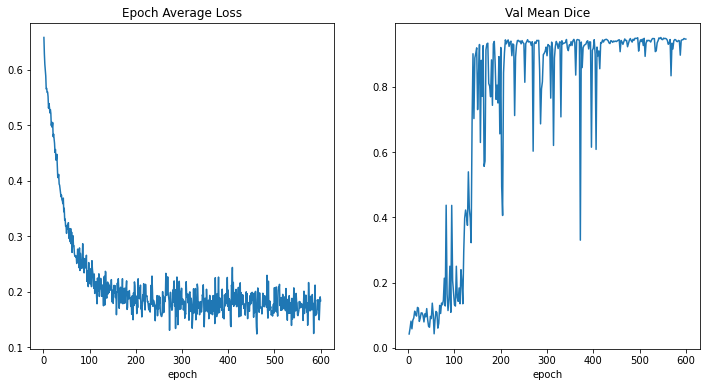

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [19]:
len(val_loader)

9

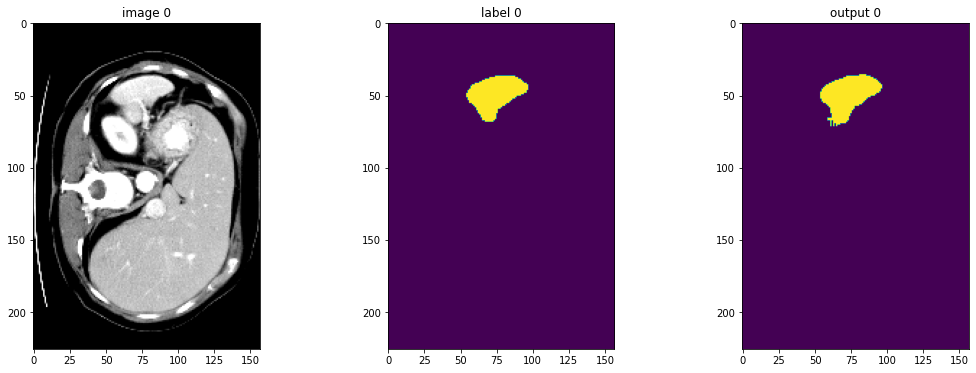

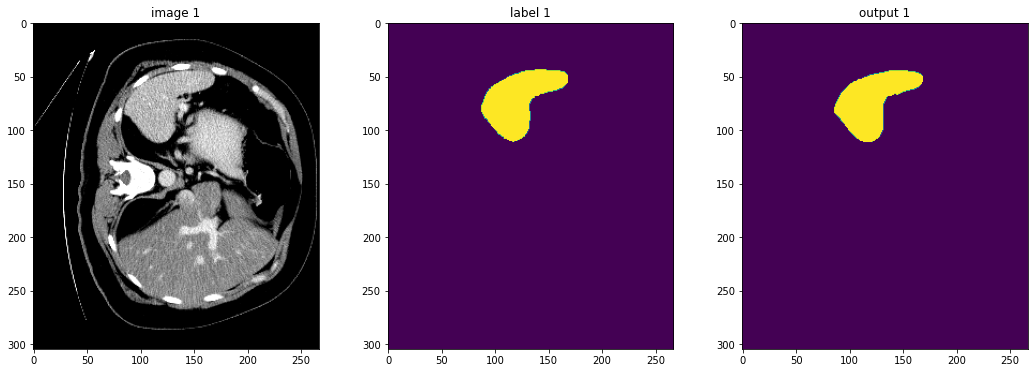

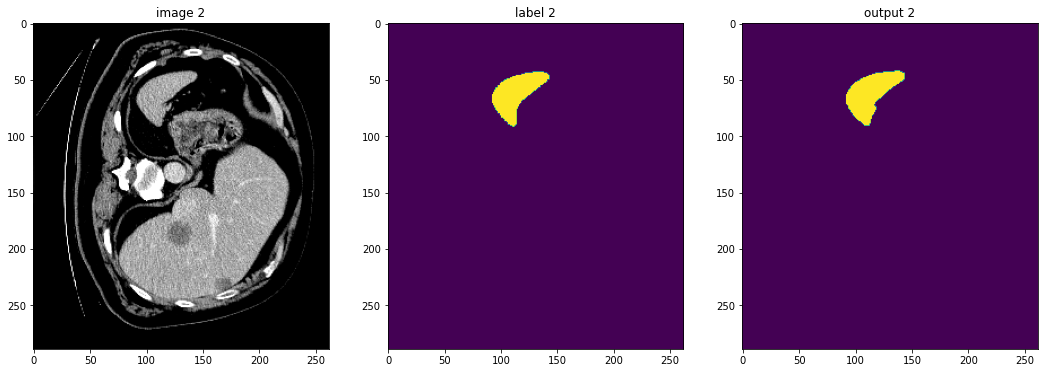

In [28]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

aa = 0
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        aa = val_outputs
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [42]:
# B, C(onehot =2), W, H , D
aa.shape

torch.Size([1, 2, 289, 262, 108])

In [45]:
aa[0,0,0,0,0], aa[0,1,0,0,0]

(tensor(4.3944, device='cuda:6'), tensor(-3.1917, device='cuda:6'))

In [30]:
aa1 = torch.argmax(aa, dim=1).detach().cpu()[0, :, :, 80]
aa1

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [40]:
torch.argmax(aa, dim=1).shape

torch.Size([1, 289, 262, 108])

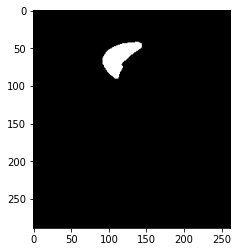

In [47]:
plt.imshow(torch.argmax(aa, dim=1).cpu()[0, :, :, 80], cmap="gray")

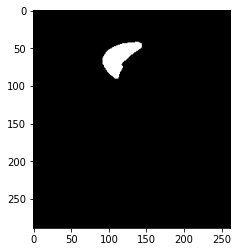

In [48]:
plt.imshow(torch.argmax(aa, dim=1).detach().cpu()[0, :, :, 80], cmap="gray")

## Evaluation on original image spacings

참고 : 위에서 진행했던 validation transofrm
```python
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)
```

In [49]:
## 위의 transform과 같아보이나, spacingd, cropforegrounded 두가지 transform에서 label까지 함께 transform했었고 
# 아래는 pred에서 어짜피 복구할모양이라 label을 빼고 transform했다. 
# 즉, metrics을 제대로 계산하려면 invertd로 pred를 복구하여 계산해야 한다.
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(     # 왜 invertd를 써야 하는지...? 안쓰면 어케 됌?
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])


In [98]:
### transform 적용, 이후의 차이 실험
### 실험결과 : spacing과 cropForeground는 기존의 이미지 dim size를 변화 시킨다.

val_org_transforms_test = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
#         CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_org_ds_test = Dataset(data=val_files, transform=val_org_transforms_test)
val_org_loader_test = DataLoader(val_org_ds_test, batch_size=1, num_workers=4)
bbb = first(val_org_loader_test)
bbb['image'].shape, bbb['label'].shape

# 모든것 다 활성화 : (torch.Size([1, 1, 226, 157, 113]), torch.Size([1, 1, 512, 512, 33]))
# spacing 비활성화 : (torch.Size([1, 1, 487, 338, 33]), torch.Size([1, 1, 512, 512, 33]))
# spacing +  cropforeground 비활성화 : (torch.Size([1, 1, 512, 512, 33]), torch.Size([1, 1, 512, 512, 33]))
# cropfoereground 비활성화 : (torch.Size([1, 1, 239, 239, 113]), torch.Size([1, 1, 512, 512, 33]))

# 결국 spacing으로 voxel 1차 축소, cropforeground로 더욱 축소됨.
# 결론. spacing, cropfoereground를 적용하려면 inference때 post process로 복구해야 한다.? 
# 그럼 학습할땐 어케 한거임..?

(torch.Size([1, 1, 239, 239, 113]), torch.Size([1, 1, 512, 512, 33]))

In [51]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [52]:
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9640673398971558


-------------

위의 내용을 좀 뜯어보자 (왜 post transform에 invert가 들어가는지도 의문

In [75]:
# 별의 별 meta내용이 다 들어가 있구만
# val_data_test = first(val_org_loader)
val_data_test = next(iter(val_org_loader))
len(val_data_test), val_data_test

(8,
 {'image': tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]],
  
            [[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]],
  
            [[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]],
  
            ...,
  
            [[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
 

In [76]:
val_inputs = val_data_test["image"].to(device)
roi_size = (160, 160, 160)
sw_batch_size = 4
val_data_test["pred"] = sliding_window_inference(
    val_inputs, roi_size, sw_batch_size, model)

In [88]:
val_data_test['image'].shape, val_data_test['label'].shape

(torch.Size([1, 1, 226, 157, 113]), torch.Size([1, 1, 512, 512, 33]))

In [77]:
val_data_test['pred'].shape

torch.Size([1, 2, 226, 157, 113])

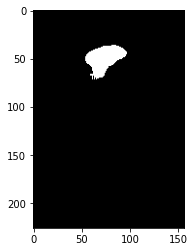

In [78]:
img_test = torch.argmax(val_data_test['pred'], dim=1).detach().cpu()[0, :, :, 80]
plt.imshow(img_test, cmap="gray")

In [86]:
val_data_test1 = [post_transforms(i) for i in decollate_batch(val_data_test)]
val_outputs, val_labels = from_engine(["pred", "label"])(val_data_test1)
val_outputs[0].shape, val_labels[0].shape
# val_outputs

(torch.Size([2, 512, 512, 33]), torch.Size([2, 512, 512, 33]))

In [99]:
dice_metric(y_pred=val_outputs, y=val_labels)

tensor([[0.9359]])

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)